In [2]:

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import pandas as pd
import numpy as np
import hashlib

from data_loader.loader import load_buggy_dataset, load_data, save_data
from bug_detective.detective import process_prompt_dataset
from utils.visualization import compare_groundtruth_vs_corrected_histograms, compare_metrics_versus_bug_histograms, plot_column_distribution, plot_metrics_boxplots
from utils.simple_metrics import compute_and_store_metrics
from typing import Dict,List


data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/'
buggy_train_df = load_buggy_dataset('train')

In [3]:
df_base = load_data('df_base_cleaned.pkl')

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from utils.simple_metrics import get_normalized_ast, _calculate_ast_similarity
import ast
import difflib

# Exemplo prático para o artigo
print("=== EXEMPLO DE NORMALIZAÇÃO AST ===\n")

# Exemplo usando dados reais do dataset
# Seleciona duas amostras do buggy_train_df para comparar ASTs
original_code = df_base.iloc[10]['before_merge_without_docstrings']
repaired_code = df_base.iloc[10]['after_merge_without_docstrings']

print("CÓDIGO ORIGINAL:")
print(original_code)
print("\nCÓDIGO REPARADO:")
print(repaired_code)

print("\n" + "="*50)

# AST bruto (sem normalização)
print("\nAST BRUTO (sem normalização):")
print("Original:")
print(ast.dump(ast.parse(original_code), indent=2))
print("\nReparado:")
print(ast.dump(ast.parse(repaired_code), indent=2))

print("\n" + "="*50)

# AST normalizado usando as funções do projeto
print("\nAST NORMALIZADO:")
print("Original:")
print(get_normalized_ast(original_code))
print("\nReparado:")
print(get_normalized_ast(repaired_code))

print("\n" + "="*50)

# Comparação de similaridade usando as funções do projeto
ast_similarity = _calculate_ast_similarity(original_code, repaired_code)

# Para AST normalizado, precisamos calcular manualmente usando difflib
original_normalized = get_normalized_ast(original_code)
repaired_normalized = get_normalized_ast(repaired_code)
normalized_similarity = difflib.SequenceMatcher(None, original_normalized, repaired_normalized).ratio()

print(f"\nRESULTADOS:")
print(f"AST Score (bruto): {ast_similarity:.4f}")
print(f"AST Score (normalizado): {normalized_similarity:.4f}")

print(f"\nINTERPRETAÇÃO:")
print(f"- AST bruto: {ast_similarity:.1%} similar (diferenças de nomenclatura)")
print(f"- AST normalizado: {normalized_similarity:.1%} similar (estrutura idêntica)")

print(f"\nCONCLUSÃO:")
if normalized_similarity > ast_similarity:
    print("✓ O AST normalizado revela que a estrutura lógica foi preservada")
    print("✓ As diferenças são apenas nomenclatura, não estrutura")
else:
    print("✗ O reparo alterou a estrutura lógica do código")

=== EXEMPLO DE NORMALIZAÇÃO AST ===

CÓDIGO ORIGINAL:
def check_status(monster, status_name):
    return any(t for t in monster.status if t.name == status_name)

CÓDIGO REPARADO:
def check_status(monster, status_name):
    return any(t for t in monster.status if t.slug == status_name)


AST BRUTO (sem normalização):
Original:
Module(
  body=[
    FunctionDef(
      name='check_status',
      args=arguments(
        posonlyargs=[],
        args=[
          arg(arg='monster'),
          arg(arg='status_name')],
        kwonlyargs=[],
        kw_defaults=[],
        defaults=[]),
      body=[
        Return(
          value=Call(
            func=Name(id='any', ctx=Load()),
            args=[
              GeneratorExp(
                elt=Name(id='t', ctx=Load()),
                generators=[
                  comprehension(
                    target=Name(id='t', ctx=Store()),
                    iter=Attribute(
                      value=Name(id='monster', ctx=Load()),
               

# Dataset metrics


In [9]:
buggy_train_df = load_buggy_dataset('train')

/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_35735/3632635005.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


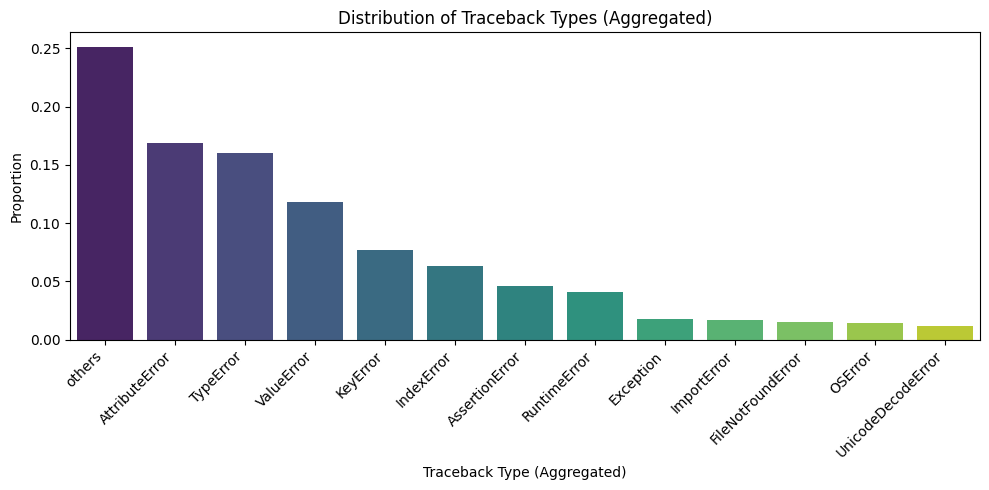

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

traceback_counts = buggy_train_df['traceback_type'].value_counts(normalize=True)
major_categories = traceback_counts[traceback_counts >= 0.01].index.tolist()

def aggregate_traceback_type(row):
    if row['traceback_type'] in major_categories:
        return row['traceback_type']
    else:
        return 'others'

buggy_train_df['traceback_type_agg'] = buggy_train_df.apply(aggregate_traceback_type, axis=1)

# Calculate the new distribution
traceback_agg_dist = buggy_train_df['traceback_type_agg'].value_counts(normalize=True)

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(
    x=traceback_agg_dist.index, 
    y=traceback_agg_dist.values, 
    palette="viridis"
)
plt.ylabel("Proportion")
plt.xlabel("Traceback Type (Aggregated)")
plt.title("Distribution of Traceback Types (Aggregated)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [11]:
traceback_agg_dist

others                0.251169
AttributeError        0.168437
TypeError             0.160008
ValueError            0.118289
KeyError              0.076640
IndexError            0.063111
AssertionError        0.045899
RuntimeError          0.040728
Exception             0.017354
ImportError           0.017000
FileNotFoundError     0.015158
OSError               0.014520
UnicodeDecodeError    0.011687
Name: traceback_type_agg, dtype: float64

### Load all Experiments


In [ ]:
baseline = load_data(data_path + "300_metrics_prompt_baseline_system_none.pkl")
system_apr = load_data(data_path + "300_metrics_prompt_baseline_system_apr.pkl")
prompt_style = load_data(data_path + "300_metrics_prompt_style_based.pkl")


In [7]:
pd.set_option('display.max_columns', None)

baseline.head()

,before_merge_without_docstrings,after_merge_without_docstrings,traceback_type,full_traceback,response_qwen-2.5-coder-32b-instruct,response_codestral-2501,response_gpt-4o,response_claude-3.5-sonnet,metric_qwen-2.5-coder-32b-instruct_ast_score,metric_qwen-2.5-coder-32b-instruct_text_score,metric_qwen-2.5-coder-32b-instruct_ast_score_normalized,metric_qwen-2.5-coder-32b-instruct_codebleu,metric_qwen-2.5-coder-32b-instruct_ngram_match_score,metric_qwen-2.5-coder-32b-instruct_weighted_ngram_match_score,metric_qwen-2.5-coder-32b-instruct_syntax_match_score,metric_qwen-2.5-coder-32b-instruct_dataflow_match_score,metric_codestral-2501_ast_score,metric_codestral-2501_text_score,metric_codestral-2501_ast_score_normalized,metric_codestral-2501_codebleu,metric_codestral-2501_ngram_match_score,metric_codestral-2501_weighted_ngram_match_score,metric_codestral-2501_syntax_match_score,metric_codestral-2501_dataflow_match_score,metric_gpt-4o_ast_score,metric_gpt-4o_text_score,metric_gpt-4o_ast_score_normalized,metric_gpt-4o_codebleu,metric_gpt-4o_ngram_match_score,metric_gpt-4o_weighted_ngram_match_score,metric_gpt-4o_syntax_match_score,metric_gpt-4o_dataflow_match_score,metric_claude-3.5-sonnet_ast_score,metric_claude-3.5-sonnet_text_score,metric_claude-3.5-sonnet_ast_score_normalized,metric_claude-3.5-sonnet_codebleu,metric_claude-3.5-sonnet_ngram_match_score,metric_claude-3.5-sonnet_weighted_ngram_match_score,metric_claude-3.5-sonnet_syntax_match_score,metric_claude-3.5-sonnet_dataflow_match_score,sample_uuid,prompt
75748,"def run(self, cmd, **kwargs):\n sel...","def run(self, cmd, **kwargs):\n sel...",IndexError,An unexpected error has occurred: IndexError: ...,"def run(self, cmd, **kwargs):\n self._creat...","def run(self, cmd, **kwargs):\n self._creat...","def run(self, cmd, **kwargs):\n self._creat...","def run(self, cmd, **kwargs):\n self._creat...",0.000000,0.688742,0.000000,0.533997,0.422525,0.432303,0.600000,0.647059,0.000000,0.826667,0.000000,0.533997,0.422525,0.432303,0.600000,0.647059,0.000000,0.456522,0.000000,0.534863,4.311807e-01,0.432303,0.600000,0.647059,0.000000,0.498246,0.000000,0.484122,0.294467,0.339630,0.600000,0.647059,8caf7a732dd1acbd2731a012a8bd45fe,baseline
583899,"def process(self, argv=None, executable=No...","def process(self, argv=None, executable=No...",TypeError,[+] Downloading '/proc/sys/kernel/core_pattern...,"def process(self, argv=None, executable=None, ...","def process(self, argv=None, executable=None, ...",cwd = cwd or self.cwd\n if isinstance(c...,"def process(self, argv=None, executable=None, ...",0.000000,0.948990,0.000000,0.993589,0.997218,0.997338,0.986706,0.990654,0.000000,0.943865,1.000000,0.985848,0.987766,0.988095,0.983752,0.983645,0.000000,0.016169,1.000000,0.032636,3.489469e-36,0.005284,0.258493,0.011682,0.000000,0.807457,1.000000,0.691194,0.705416,0.741912,0.818316,0.605140,d1e8f77aa937f586008b06aabb60d1ac,baseline
532193,"def backprojection(calibrated_event_list, pixe...","def backprojection(calibrated_event_list, pixe...",TypeError,import sunpy.data\n>>> import sunpy.data.sampl...,"def backprojection(calibrated_event_list, pixe...","def backprojection(calibrated_event_list, pixe...","def backprojection(calibrated_event_list, pixe...","def backprojection(calibrated_event_list, pixe...",0.835698,0.871159,0.191445,0.681342,0.568953,0.757147,0.847458,0.592105,0.831026,0.862375,0.174448,0.666034,0.549906,0.732113,0.813559,0.592105,0.810626,0.798835,0.172004,0.637508,5.086480e-01,0.696498,0.790960,0.572368,0.714742,0.798102,0.168188,0.652772,0.529190,0.709786,0.790960,0.592105,1ca9ee95a397f49814adbe7531b4e88a,baseline
357599,"def export_annotations(self,export_range,e...","def export_annotations(self,export_range,e...",AttributeError,"Traceback (most recent call last):\nFile ""main...","def export_annotations(self, export_range, exp...","def export_annotations(self, export_range, exp...","def export_annotations(self, export_range, exp...","def export_annotations(self,export_range,expor...",0.00

In [6]:
from utils.simple_metrics import wilcoxon_test, has_metrics_columns

# Example: Compare two sets of metrics between experiments using Wilcoxon signed-rank test
# Let's assume we want to compare 'accuracy' between baseline and system_apr
def wilcoxon_test_cross_dataset_simple(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    model_name: str,
    metric_name: str = "ast_score",
    reference_column: str = "after_merge_without_docstrings",
    id_column: str = "bug_id",
    alternative: str = "two-sided"
) -> Dict[str, float]:
    """Perform Wilcoxon test for the same model across two datasets using existing function.
    
    This function reuses the existing wilcoxon_test by merging datasets and creating
    separate response columns for each dataset.
    
    Args:
        df1 (pd.DataFrame): First dataset DataFrame
        df2 (pd.DataFrame): Second dataset DataFrame  
        model_name (str): Name of the model to compare (e.g., "gpt4", "claude")
        metric_name (str): Name of the metric to compare (default: "ast_score")
        reference_column (str): Reference column used for metric calculation
        id_column (str): Column name to match instances across datasets
        alternative (str): Alternative hypothesis: "two-sided", "greater", or "less"
    
    Returns:
        Dict[str, float]: Dictionary containing test results from existing wilcoxon_test
    """
    # Find the response column for the specified model in each dataset
    response_col1 = None
    response_col2 = None
    
    for col in df1.columns:
        if col.startswith("response_") and model_name.lower() in col.lower():
            response_col1 = col
            break
            
    for col in df2.columns:
        if col.startswith("response_") and model_name.lower() in col.lower():
            response_col2 = col
            break
    
    if not response_col1:
        raise ValueError(f"Model '{model_name}' not found in dataset 1")
    if not response_col2:
        raise ValueError(f"Model '{model_name}' not found in dataset 2")
    
    # Ensure metrics are computed for both datasets
    if not has_metrics_columns(df1, response_col1):
        print(f"Computing metrics for dataset 1...")
        df1 = compute_and_store_metrics(df1, reference_column, [response_col1])
    
    if not has_metrics_columns(df2, response_col2):
        print(f"Computing metrics for dataset 2...")
        df2 = compute_and_store_metrics(df2, reference_column, [response_col2])
    
    # Get metric column names
    clean_model_name = response_col1.replace("response_", "")
    metric_col1 = f"metric_{clean_model_name}_{metric_name}"
    metric_col2 = f"metric_{clean_model_name}_{metric_name}"
    

    merged_df = pd.merge(
        df1[[id_column, metric_col1]], 
        df2[[id_column, metric_col2]], 
        on=id_column, 
        how='inner',
        suffixes=('_dataset1', '_dataset2')
    )
    
    # Create a unified DataFrame that mimics the structure expected by wilcoxon_test
    unified_df = pd.DataFrame({
        id_column: merged_df[id_column],
        "response_dataset1": merged_df[metric_col1 + "_dataset1"],
        "response_dataset2": merged_df[metric_col2 + "_dataset2"],
        "dummy_reference": merged_df[metric_col1 + "_dataset1"]  # For compatibility
    })
    
    # Use the existing wilcoxon_test function directly!
    return wilcoxon_test(
        df=unified_df,
        response_column1="response_dataset1",
        response_column2="response_dataset2",
        metric_name=metric_name,  # This won't be used since we're passing metric values directly
        reference_column="dummy_reference",
        alternative=alternative
    )

In [7]:

# Compare GPT-4 performance across experiments using existing function
results = wilcoxon_test_cross_dataset_simple(
    df1=baseline,
    df2=system_apr,
    model_name="qwen-2.5-coder-32b-instruct",
    metric_name="codebleu",
    id_column="sample_uuid"
)

print(f"Cross-dataset Wilcoxon test results:")
print(f"p-value: {results['pvalue']:.6f}")
print(f"Significant difference: {'Yes' if results['significant'] else 'No'}")
print(f"Effect size: {results['effect_size']:.4f}")
print(f"Matching instances: {results['matching_instances']}")

NameError: name 'baseline' is not defined